In [1]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Identification of Cointegrated Pairs of Stocks

In [2]:
# read back the pricing data
prices = pd.read_csv('oil_and_gas.csv', index_col=['date'])
prices.head(10)

RELIANCE.NS     ONGC.NS     BPCL.NS      IOC.NS     GAIL.NS  \
date                                                                      
01-01-2018   901.207459  192.350006  508.600006  194.975006  186.993790   
02-01-2018   902.594299  196.850006  499.799988  193.199997  185.381302   
03-01-2018   906.210022  193.449997  494.899994  193.149994  183.787552   
04-01-2018   911.658386  199.500000  491.500000  193.649994  186.262543   
05-01-2018   914.580688  198.449997  487.700012  191.925003  185.400040   
08-01-2018   919.830933  197.399994  497.200012  194.274994  186.525040   
09-01-2018   932.114502  197.000000  496.100006  196.199997  187.856293   
10-01-2018   933.501343  197.899994  494.299988  194.774994  186.037552   
11-01-2018   928.944519  197.899994  492.399994  194.449997  185.812546   
12-01-2018   940.088867  200.750000  489.899994  194.524994  187.931290   

            HINDPETRO.NS      IGL.NS  PETRONET.NS  GUJGASLTD.NS  
date                                                             
01-01-2018    413.750000  339.750000   255.899994    168.830002  
02-01-2018    406.399994  335.200012   252.750000    169.399994  
03-01-2018    410.950012  332.750000   253.600006    174.639999  
04-01-2018    418.850006  329.049988   252.699997    169.910004  
05-01-2018    415.000000  329.850006   252.149994    174.179993  
08-01-2018    421.149994  328.200012   254.699997    177.100006  
09-01-2018    417.250000  323.049988   253.199997    174.460007  
10-01-2018    424.549988  325.750000   251.000000    172.149994  
11-01-2018    420.950012  322.250000   249.449997    174.789993  
12-01-2018    425.899994  327.500000   252.500000    181.929993

In [3]:
# train test split 
train_close, test_close = train_test_split(prices, test_size=0.251012, shuffle=False)

In [4]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

RELIANCE.NS     ONGC.NS     BPCL.NS      IOC.NS     GAIL.NS  \
date                                                                      
01-01-2018   901.207459  192.350006  508.600006  194.975006  186.993790   
02-01-2018   902.594299  196.850006  499.799988  193.199997  185.381302   
30-12-2020  1995.500000   93.250000  382.850006   90.900002  123.099998   
31-12-2020  1985.300049   93.050003  381.100006   90.949997  123.250000   

            HINDPETRO.NS      IGL.NS  PETRONET.NS  GUJGASLTD.NS  
date                                                             
01-01-2018    413.750000  339.750000   255.899994    168.830002  
02-01-2018    406.399994  335.200012   252.750000    169.399994  
30-12-2020    216.449997  505.549988   246.500000    382.200012  
31-12-2020    217.899994  502.350006   247.600006    376.399994

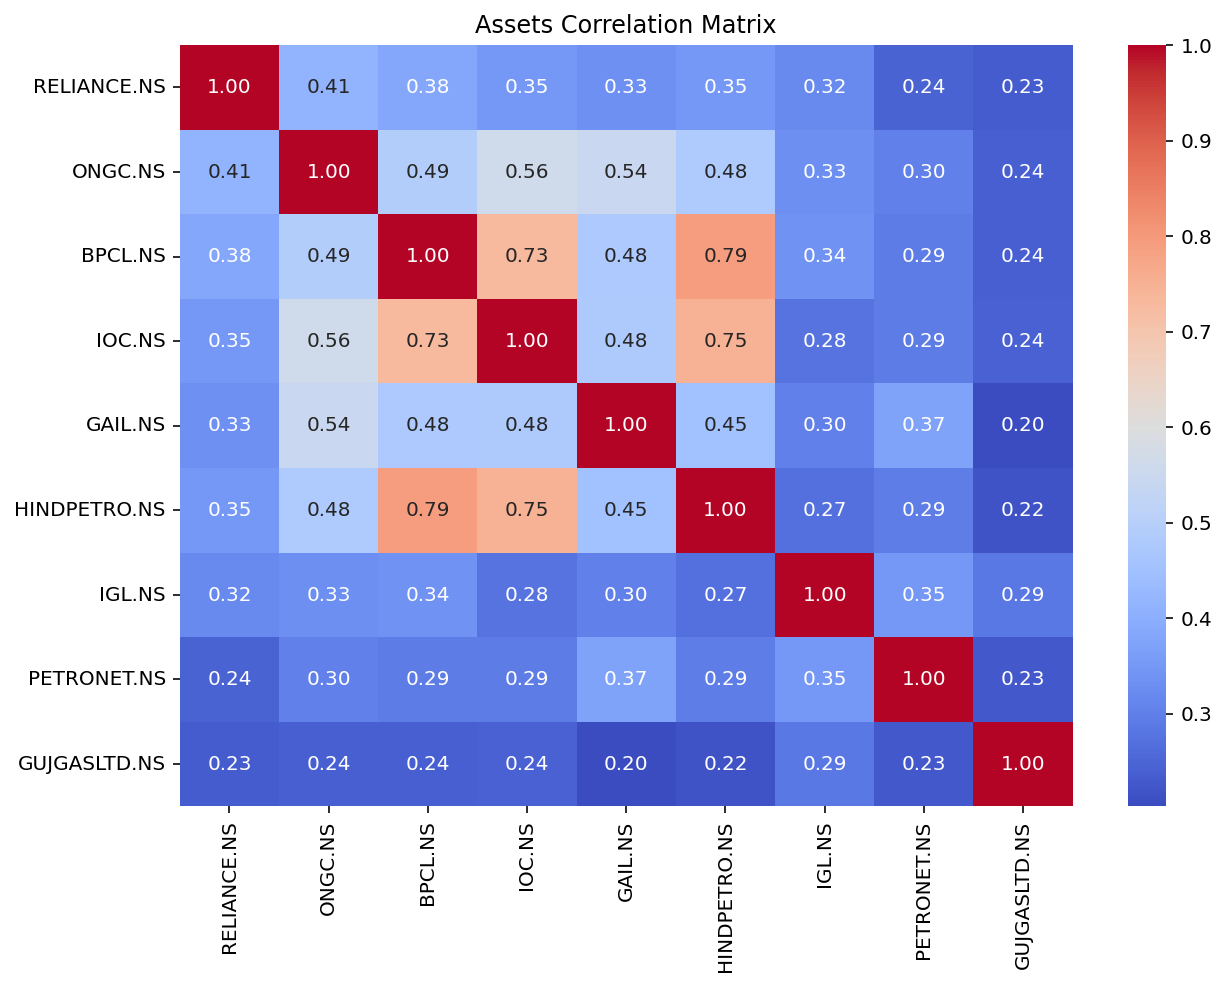

In [5]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=400)

In [6]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('ONGC.NS', 'IOC.NS'), ('BPCL.NS', 'PETRONET.NS'), ('HINDPETRO.NS', 'IGL.NS')]


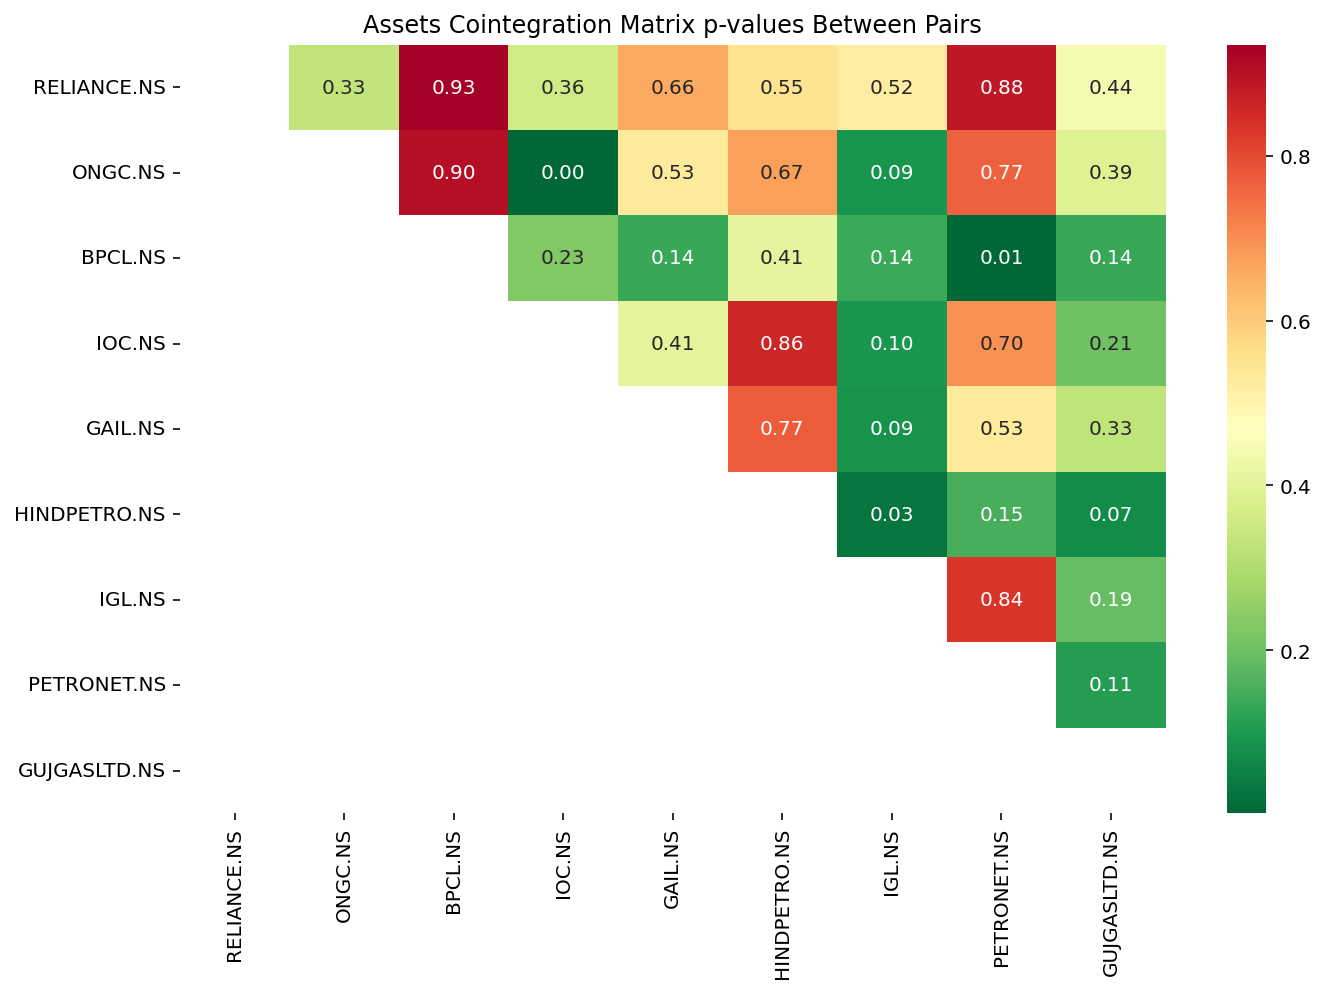

In [7]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=400) 

### Perform a Cointegration test for the Selected Pair

In [8]:
# final pair to test strategy
asset1 = 'HINDPETRO.NS'
asset2 = 'GUJGASLTD.NS'

In [9]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

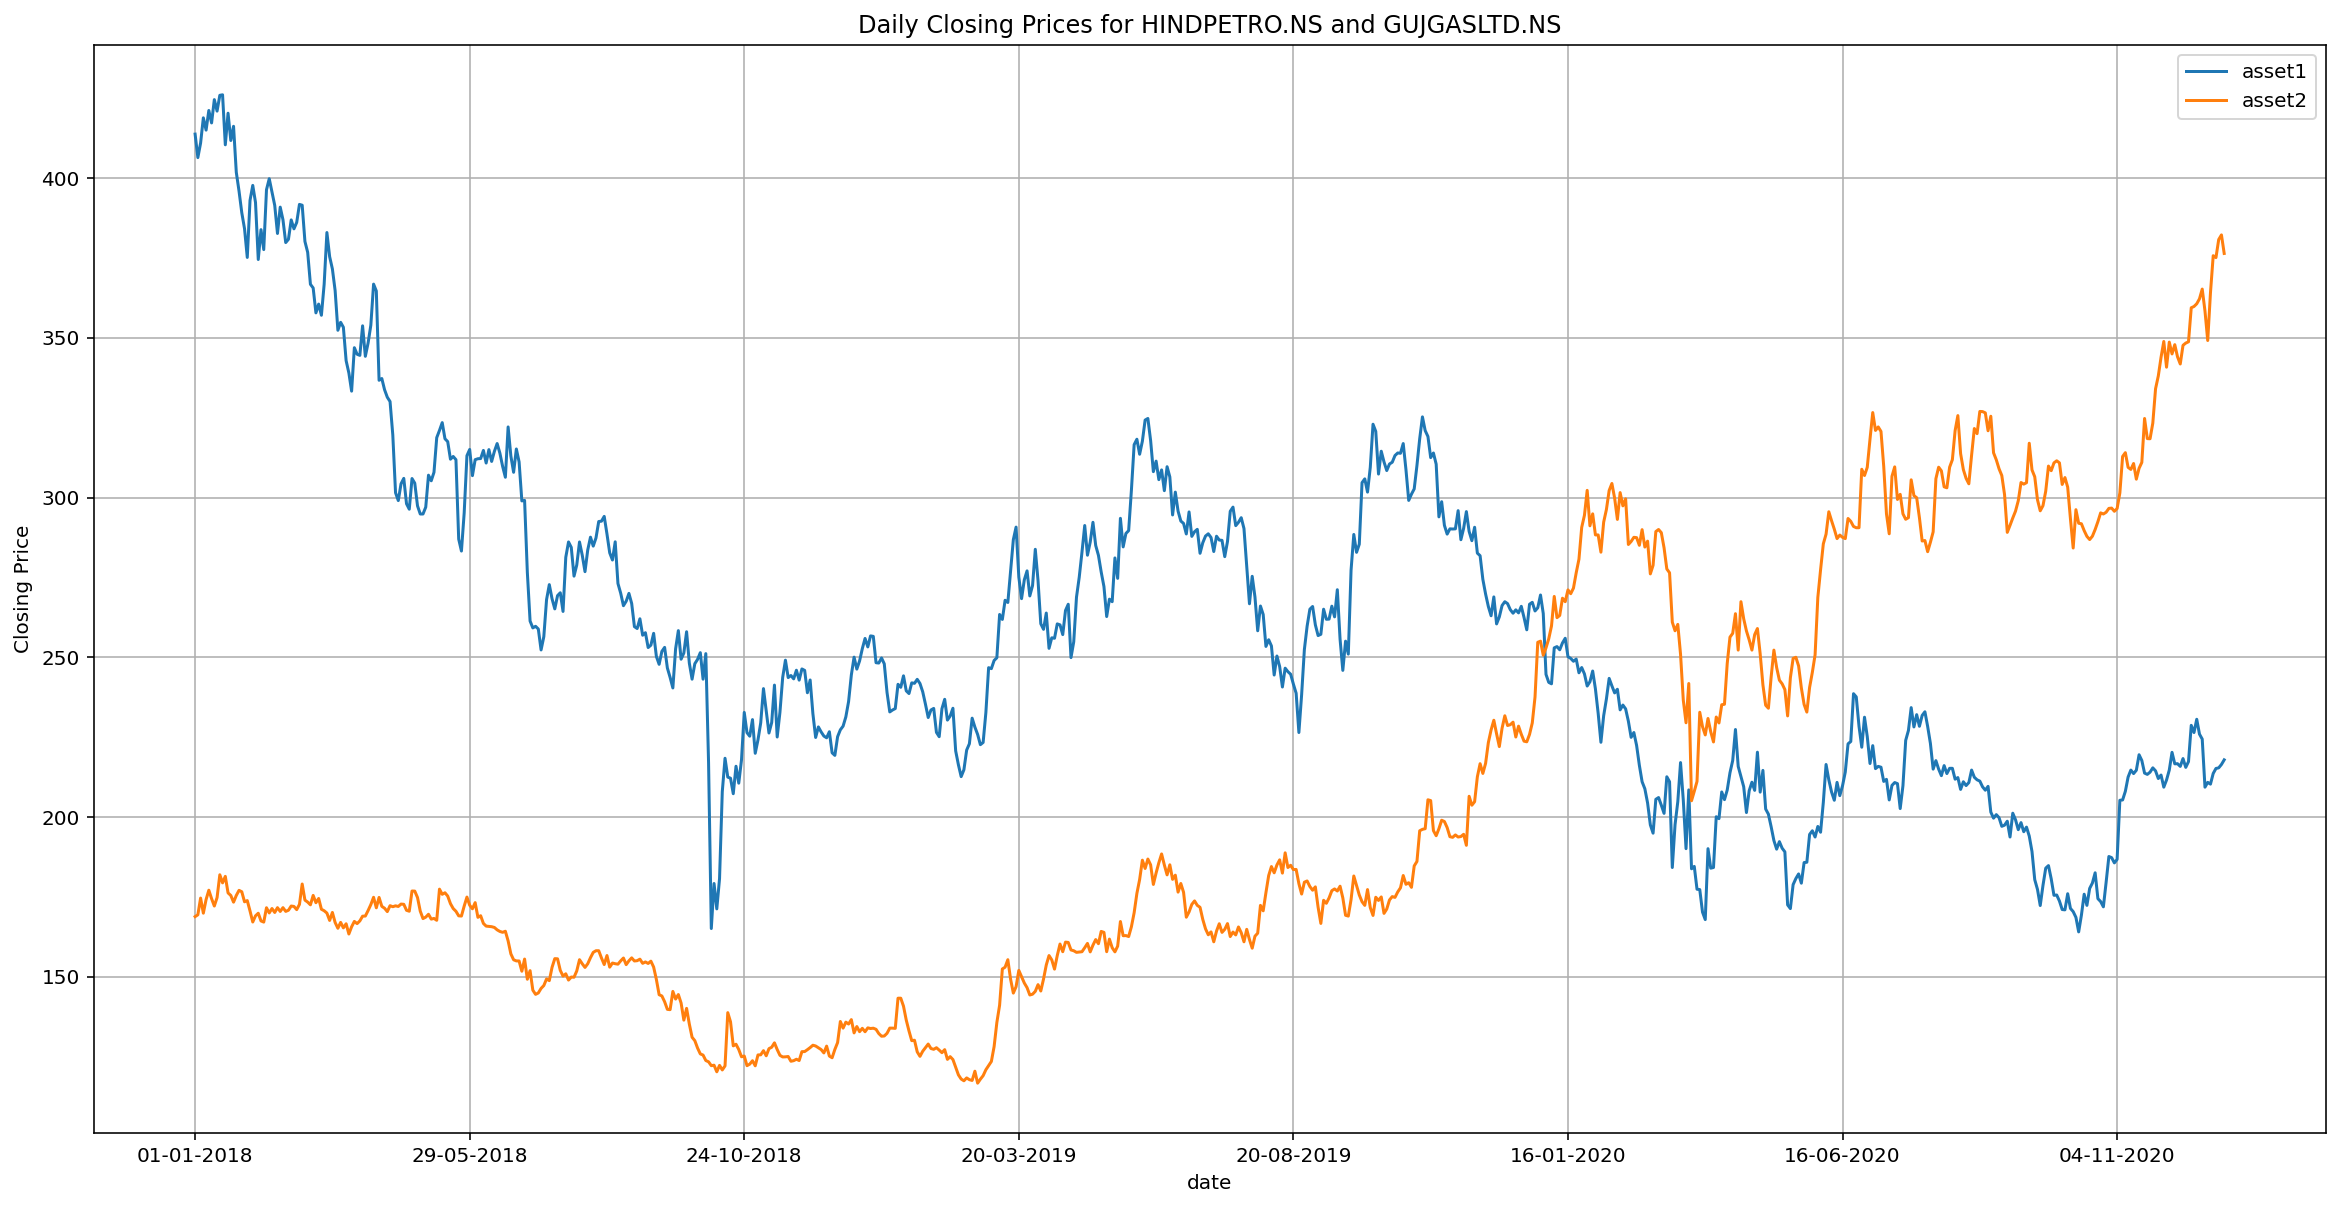

In [10]:
from matplotlib.dates import DateFormatter
# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(20, 10), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
#date_form = DateFormatter("%Y")
# ax.xaxis.set_major_formatter(date_form)
ax.grid(True);
plt.savefig('chart3', dpi=400) 

In [11]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 asset2   R-squared (uncentered):                   0.806
Model:                            OLS   Adj. R-squared (uncentered):              0.805
Method:                 Least Squares   F-statistic:                              3064.
Date:                Mon, 21 Mar 2022   Prob (F-statistic):                   4.32e-265
Time:                        00:36:01   Log-Likelihood:                         -4422.6
No. Observations:                 740   AIC:                                      8847.
Df Residuals:                     739   BIC:                                      8852.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
asset1         0.7314      0.013     55.350      0.000       0.705       0.757
==============================================================================
Omnibus:                      322.856   Durbin-Watson:                   0.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.184
Skew:                           0.577   Prob(JB):                     6.39e-18
Kurtosis:                       1.887   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

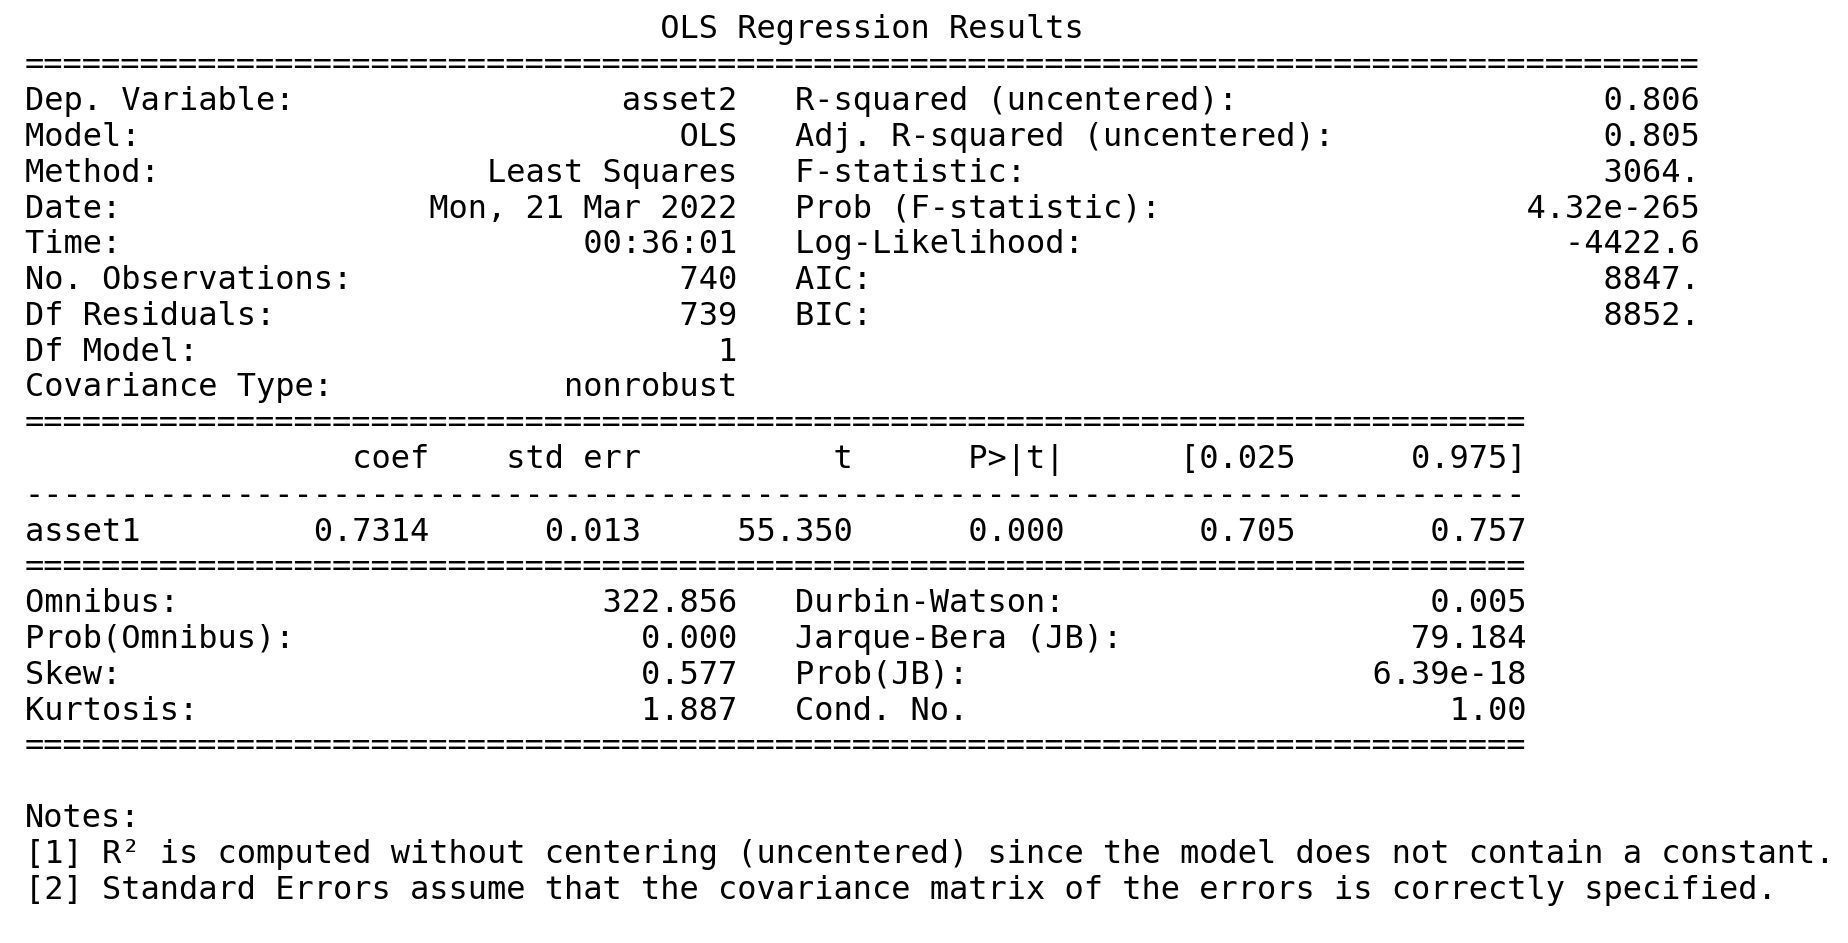

In [13]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=400);

In [14]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  0.7313911820460108


In [15]:
# calculate spread
spread = train.asset2 - model.params[0] * train.asset1

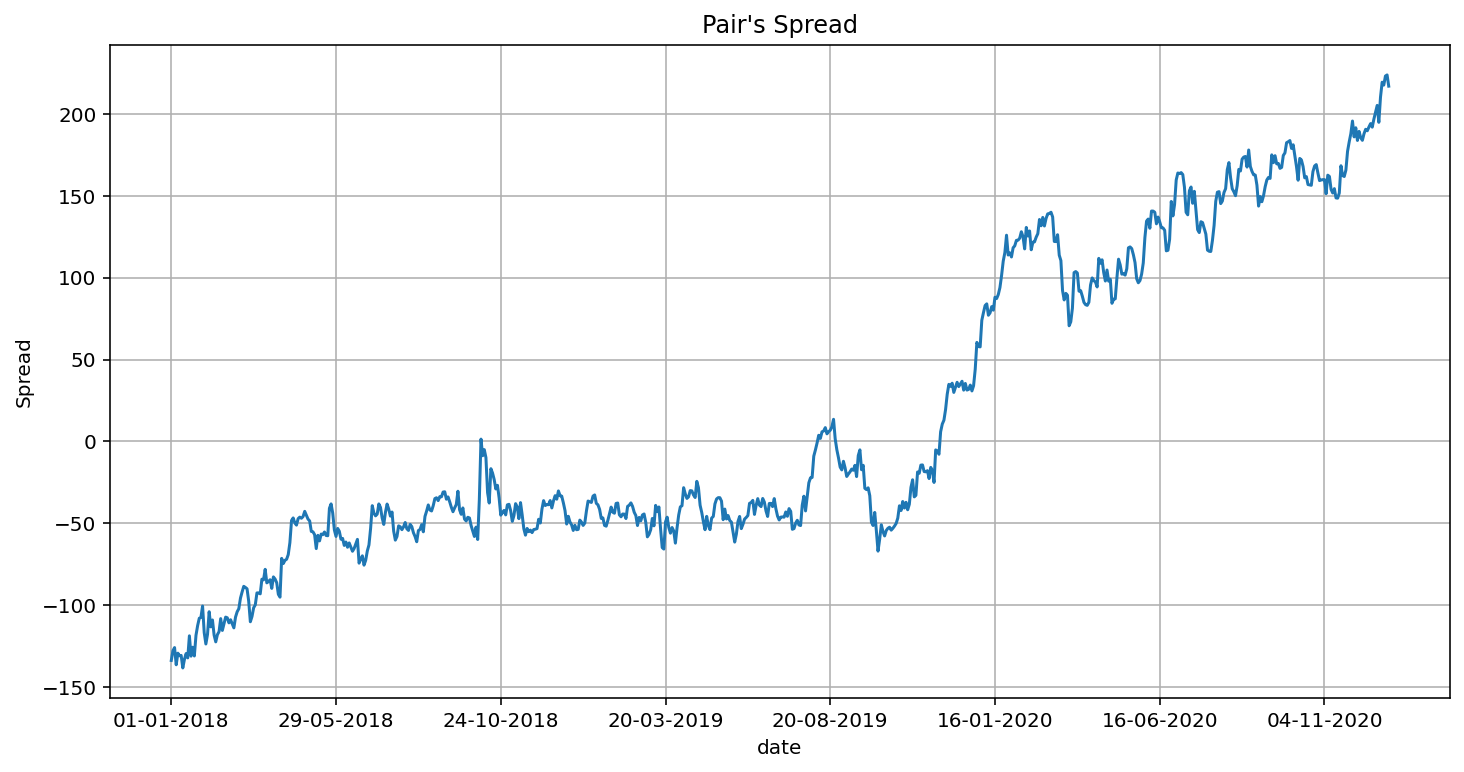

In [16]:
# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);
plt.savefig('chart5', dpi=400);

In [17]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
adf

(-0.36520525693986633,
 0.9157481711879114,
 0,
 739,
 {'1%': -3.439229783394421,
  '5%': -2.86545894814762,
  '10%': -2.5688568756191392},
 4839.084594943377)

In [18]:
print('Critical Value = ', adf[0])

Critical Value =  -0.36520525693986633


In [19]:
# probablity critical values
print(adf[4])

{'1%': -3.439229783394421, '5%': -2.86545894814762, '10%': -2.5688568756191392}


### Generate Trading Signals using z-score

In [20]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [21]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [22]:
signals.head()

asset1      asset2
date                              
01-01-2021  221.250000  378.000000
04-01-2021  222.750000  379.350006
05-01-2021  223.100006  389.549988
06-01-2021  220.949997  386.299988
07-01-2021  222.800003  386.850006

In [23]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [24]:
signals.head()

asset1      asset2         z  z upper limit  z lower limit
date                                                                      
01-01-2021  221.250000  378.000000  1.726191            1.0           -1.0
04-01-2021  222.750000  379.350006  1.754186            1.0           -1.0
05-01-2021  223.100006  389.549988  1.537594            1.0           -1.0
06-01-2021  220.949997  386.299988  1.526413            1.0           -1.0
07-01-2021  222.800003  386.850006  1.585796            1.0           -1.0

In [25]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [26]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

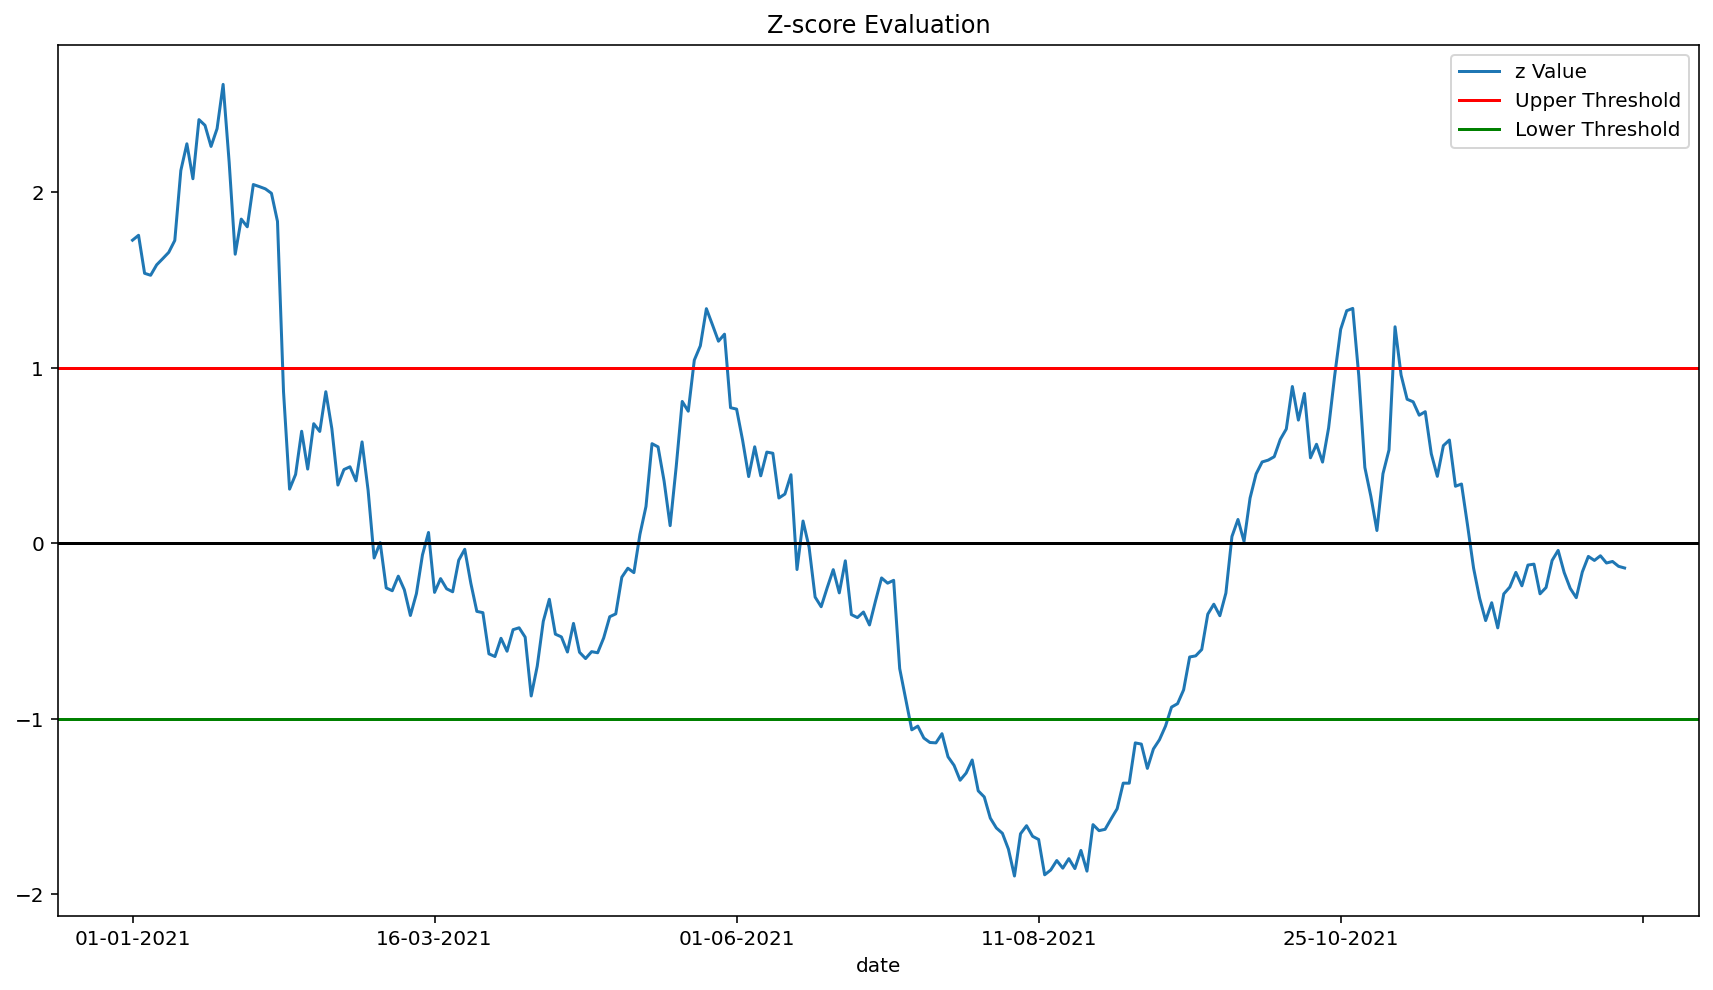

In [27]:
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value")
plt.title("Z-score Evaluation")
plt.axhline(signals['z'].mean(),color="black")
plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('chart6', dpi=400);

In [28]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  221.250000  378.000000  1.726191            1.0           -1.0   
04-01-2021  222.750000  379.350006  1.754186            1.0           -1.0   
05-01-2021  223.100006  389.549988  1.537594            1.0           -1.0   
29-12-2021  292.399994  631.549988 -0.104063            1.0           -1.0   
30-12-2021  288.649994  625.950012 -0.131725            1.0           -1.0   
31-12-2021  292.350006  634.849976 -0.141248            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
05-01-2021        -1         0.0         1         0.0  
29-12-2021         0         0.0         0         0.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         0         0.0         0         0.0

In [29]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  221.250000  378.000000  1.726191            1.0           -1.0   
04-01-2021  222.750000  379.350006  1.754186            1.0           -1.0   
05-01-2021  223.100006  389.549988  1.537594            1.0           -1.0   
06-01-2021  220.949997  386.299988  1.526413            1.0           -1.0   
07-01-2021  222.800003  386.850006  1.585796            1.0           -1.0   
08-01-2021  225.500000  389.950012  1.620888            1.0           -1.0   
11-01-2021  224.350006  386.350006  1.656973            1.0           -1.0   
12-01-2021  224.899994  384.299988  1.724731            1.0           -1.0   
13-01-2021  227.149994  371.250000  2.123189            1.0           -1.0   
14-01-2021  233.600006  375.549988  2.275338            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
05-01-2021        -1         0.0         1         0.0  
06-01-2021        -1         0.0         1         0.0  
07-01-2021        -1         0.0         1         0.0  
08-01-2021        -1         0.0         1         0.0  
11-01-2021        -1         0.0         1         0.0  
12-01-2021        -1         0.0         1         0.0  
13-01-2021        -1         0.0         1         0.0  
14-01-2021        -1         0.0         1         0.0

In [30]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  221.250000  378.000000  1.726191            1.0           -1.0   
08-02-2021  229.550003  435.100006  0.862341            1.0           -1.0   
21-05-2021  276.299988  512.000000  1.042906            1.0           -1.0   
31-05-2021  279.700012  536.299988  0.771922            1.0           -1.0   
12-07-2021  271.899994  681.650024 -1.063148            1.0           -1.0   
14-09-2021  274.149994  672.700012 -0.933704            1.0           -1.0   
25-10-2021  323.049988  585.900024  1.218339            1.0           -1.0   
28-10-2021  317.049988  594.150024  0.952702            1.0           -1.0   
08-11-2021  345.799988  626.049988  1.232974            1.0           -1.0   
09-11-2021  344.549988  645.250000  0.958083            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
08-02-2021         0         1.0         0        -1.0  
21-05-2021        -1        -1.0         1         1.0  
31-05-2021         0         1.0         0        -1.0  
12-07-2021         1         1.0        -1        -1.0  
14-09-2021         0        -1.0         0         1.0  
25-10-2021        -1        -1.0         1         1.0  
28-10-2021         0         1.0         0        -1.0  
08-11-2021        -1        -1.0         1         1.0  
09-11-2021         0         1.0         0        -1.0

In [31]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

229.550003    1
279.700012    1
271.899994    1
317.049988    1
344.549988    1
Name: asset1, dtype: int64

In [32]:
signals

asset1      asset2         z  z upper limit  z lower limit  \
date                                                                         
01-01-2021  221.250000  378.000000  1.726191            1.0           -1.0   
04-01-2021  222.750000  379.350006  1.754186            1.0           -1.0   
05-01-2021  223.100006  389.549988  1.537594            1.0           -1.0   
06-01-2021  220.949997  386.299988  1.526413            1.0           -1.0   
07-01-2021  222.800003  386.850006  1.585796            1.0           -1.0   
...                ...         ...       ...            ...            ...   
27-12-2021  290.750000  625.049988 -0.071523            1.0           -1.0   
28-12-2021  294.250000  636.349976 -0.112817            1.0           -1.0   
29-12-2021  292.399994  631.549988 -0.104063            1.0           -1.0   
30-12-2021  288.649994  625.950012 -0.131725            1.0           -1.0   
31-12-2021  292.350006  634.849976 -0.141248            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021        -1         NaN         1         NaN  
04-01-2021        -1         0.0         1         0.0  
05-01-2021        -1         0.0         1         0.0  
06-01-2021        -1         0.0         1         0.0  
07-01-2021        -1         0.0         1         0.0  
...              ...         ...       ...         ...  
27-12-2021         0         0.0         0         0.0  
28-12-2021         0         0.0         0         0.0  
29-12-2021         0         0.0         0         0.0  
30-12-2021         0         0.0         0         0.0  
31-12-2021         0         0.0         0         0.0  

[248 rows x 9 columns]

In [33]:
signals = signals.reset_index()

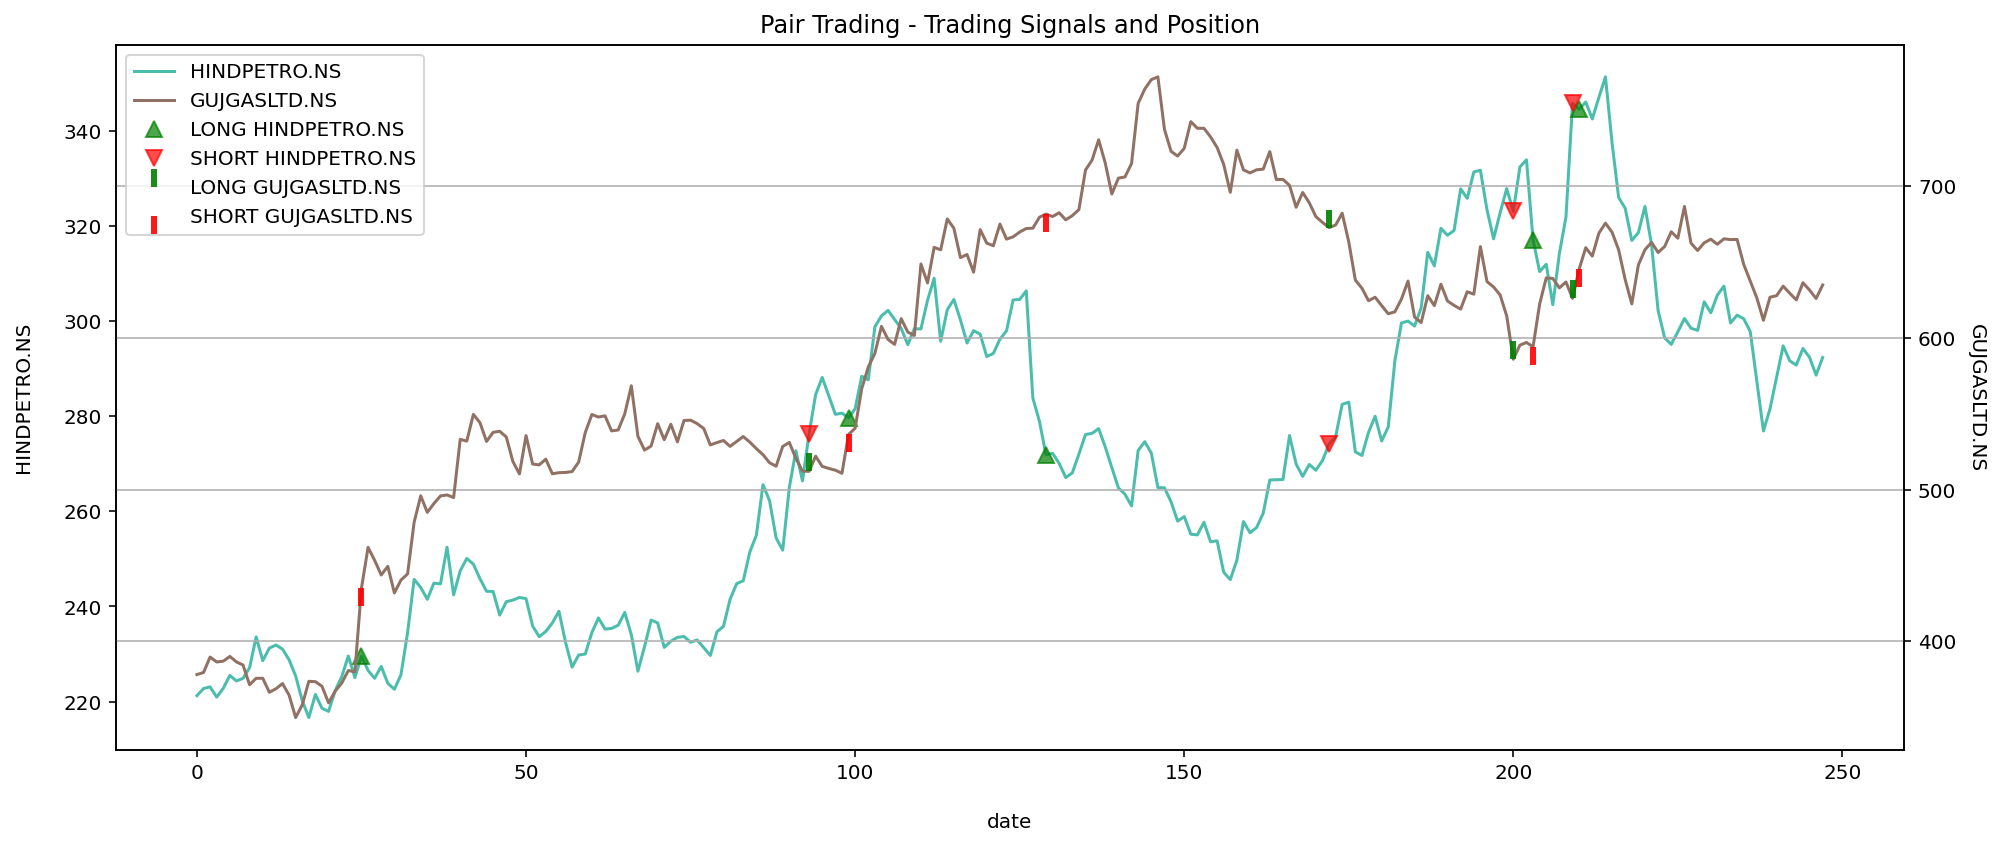

In [34]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('date')
# bx.xaxis.set_major_formatter(DateFormatter("%Y"))
# bx2.xaxis.set_major_formatter(DateFormatter("%Y"))
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=400);

### Portfolio Profit and Loss Calculation

In [35]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [36]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [37]:
portfolio.head().append(portfolio.tail())

asset1     holdings1         cash1   total asset1   return1  \
0    221.250000           NaN           NaN            NaN       NaN   
1    222.750000      0.000000  100000.00000  100000.000000       NaN   
2    223.100006      0.000000  100000.00000  100000.000000  0.000000   
3    220.949997      0.000000  100000.00000  100000.000000  0.000000   
4    222.800003      0.000000  100000.00000  100000.000000  0.000000   
243  290.750000  82573.000000   36540.19219  119113.192190 -0.002141   
244  294.250000  83567.000000   36540.19219  120107.192190  0.008345   
245  292.399994  83041.598268   36540.19219  119581.790458 -0.004374   
246  288.649994  81976.598268   36540.19219  118516.790458 -0.008906   
247  292.350006  83027.401732   36540.19219  119567.593922  0.008866   

     positions1  
0           NaN  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
243         0.0  
244         0.0  
245         0.0  
246         0.0  
247         0.0

In [38]:
portfolio[portfolio.positions1 != 0].head()

asset1      holdings1          cash1   total asset1   return1  \
0    221.250000            NaN            NaN            NaN       NaN   
25   229.550003   65192.200880   34807.799120  100000.000000  0.000000   
93   276.299988       0.000000  113276.995655  113276.995655  0.025452   
99   279.700012   79434.803465   33842.192190  113276.995655  0.000000   
129  271.899994  154439.196535  -43377.406078  111061.790458 -0.017709   

     positions1  
0           NaN  
25          1.0  
93         -1.0  
99          1.0  
129         1.0

In [39]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [40]:
portfolio.to_csv('portfolio.csv')
portfolio.head().append(portfolio.tail())

asset1     holdings1         cash1   total asset1   return1  \
0    221.250000           NaN           NaN            NaN       NaN   
1    222.750000      0.000000  100000.00000  100000.000000       NaN   
2    223.100006      0.000000  100000.00000  100000.000000  0.000000   
3    220.949997      0.000000  100000.00000  100000.000000  0.000000   
4    222.800003      0.000000  100000.00000  100000.000000  0.000000   
243  290.750000  82573.000000   36540.19219  119113.192190 -0.002141   
244  294.250000  83567.000000   36540.19219  120107.192190  0.008345   
245  292.399994  83041.598268   36540.19219  119581.790458 -0.004374   
246  288.649994  81976.598268   36540.19219  118516.790458 -0.008906   
247  292.350006  83027.401732   36540.19219  119567.593922  0.008866   

     positions1      asset2     holdings2          cash2   total asset2  \
0           NaN  378.000000           NaN            NaN            NaN   
1           0.0  379.350006      0.000000  100000.000000  100000.000000   
2           0.0  389.549988      0.000000  100000.000000  100000.000000   
3           0.0  386.299988      0.000000  100000.000000  100000.000000   
4           0.0  386.850006      0.000000  100000.000000  100000.000000   
243         0.0  625.049988 -80631.448426  163958.202361   83326.753934   
244         0.0  636.349976 -82089.146852  163958.202361   81869.055508   
245         0.0  631.549988 -81469.948426  163958.202361   82488.253934   
246         0.0  625.950012 -80747.551574  163958.202361   83210.650787   
247         0.0  634.849976 -81895.646852  163958.202361   82062.555508   

      return2  positions2  
0         NaN         NaN  
1         NaN         0.0  
2    0.000000         0.0  
3    0.000000         0.0  
4    0.000000         0.0  
243  0.006780         0.0  
244 -0.017494         0.0  
245  0.007563         0.0  
246  0.008758         0.0  
247 -0.013797         0.0

In [41]:
portfolio[portfolio.positions2 != 0].head()

asset1      holdings1          cash1   total asset1   return1  \
0    221.250000            NaN            NaN            NaN       NaN   
25   229.550003   65192.200880   34807.799120  100000.000000  0.000000   
93   276.299988       0.000000  113276.995655  113276.995655  0.025452   
99   279.700012   79434.803465   33842.192190  113276.995655  0.000000   
129  271.899994  154439.196535  -43377.406078  111061.790458 -0.017709   

     positions1      asset2      holdings2          cash2   total asset2  \
0           NaN  378.000000            NaN            NaN            NaN   
25          1.0  435.100006  -56127.900787  156127.900787  100000.000000   
93         -1.0  512.000000       0.000000   90079.900787   90079.900787   
99          1.0  536.299988  -69182.698426  159262.599213   90079.900787   
129         1.0  681.650024 -175865.706295  247195.452361   71329.746065   

          return2  positions2  
0             NaN         NaN  
25   0.000000e+00        -1.0  
93   1.431918e-04         1.0  
99   2.220446e-16        -1.0  
129 -3.873263e-03        -1.0

In [42]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

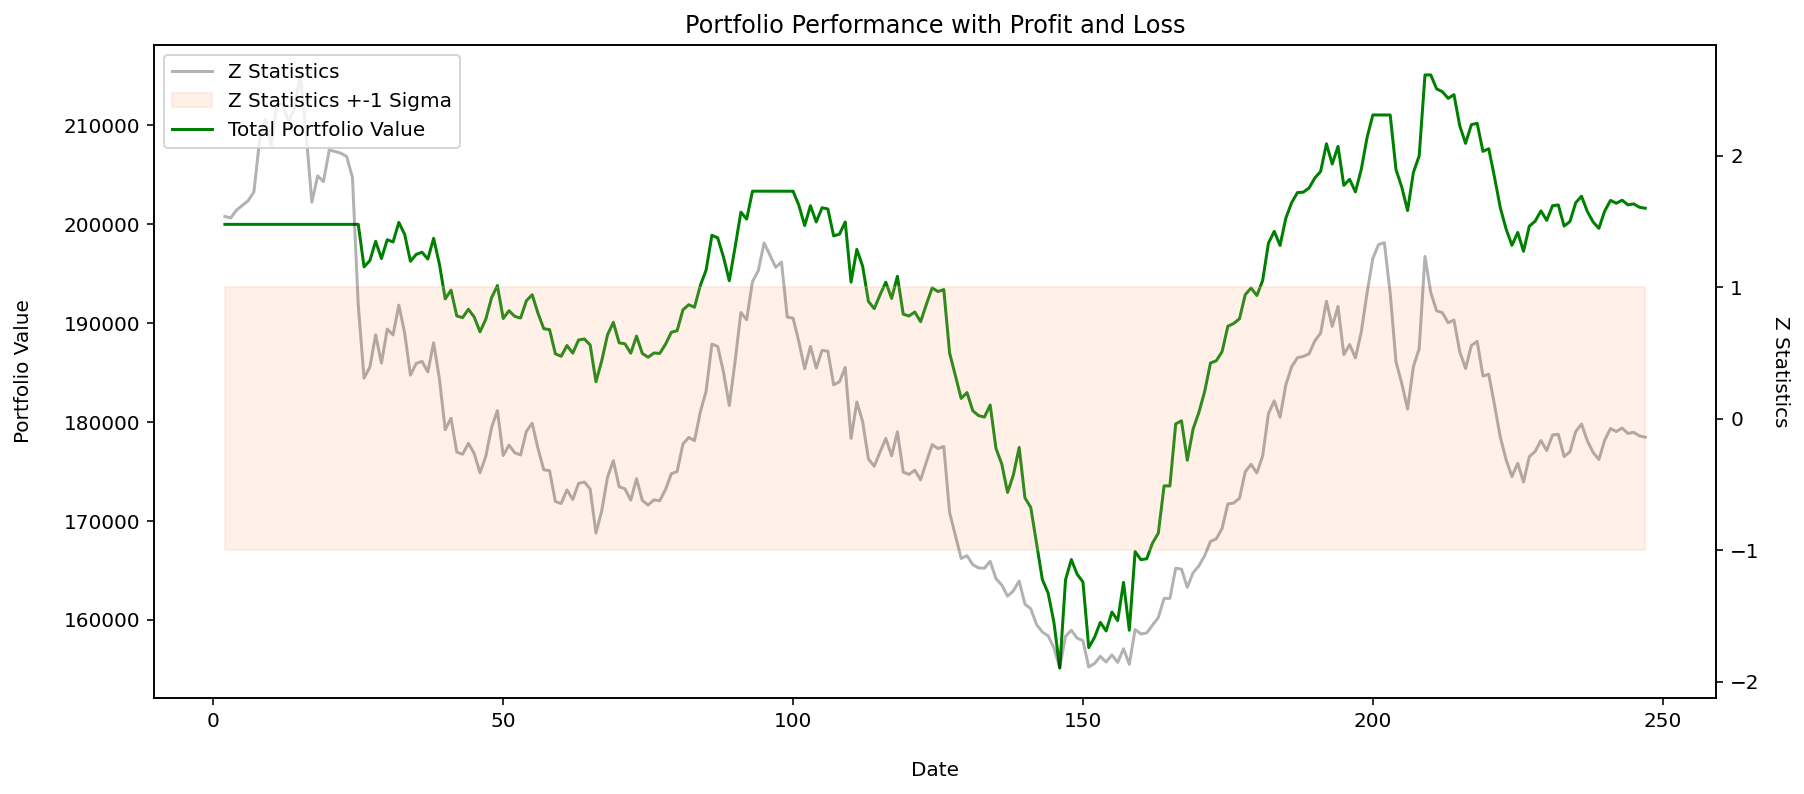

In [43]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');
plt.savefig('chart8', dpi=400);

In [44]:
#portfolio = pd.read_csv('portfolio.csv')

In [47]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
final_portfolio

201630.1494307

In [48]:
profit = final_portfolio - 2*initial_capital
profit

1630.1494306999957

In [49]:
roi = (profit /(2*initial_capital))*100
roi

0.8150747153499979

In [ ]:
# delta = (portfolio.index[-1] - portfolio.index[0]).days
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)

In [46]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 184.266%
